# Figures 6 and 12: Temporal noise
This notebook can be used to: 
- Generate/load and plot the synthetic d13C and age constraint data used for the temporal noise experiments in Fig. 12
- Build and sample the inference model using proxy observations from synthetic sections with depositional histories raning from episodic to uniform
- Load the inference results from the model runs used to produce Fig. 12
- Quantify signal recovery for each experiment
- Reproduce Fig. 12 using the provided inference results

In [1]:
%load_ext autoreload
%autoreload 2

import arviz as az
import math
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import pandas as pd
import seaborn as sns
import stratmc

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Avenir']
rcParams.update({
    "text.usetex": False
})

from scipy.ndimage import gaussian_filter as gaussian
from scipy.stats import gaussian_kde, norm

from tqdm.notebook import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Synthetic d13C signal (Fig. 6a)

(130.0, 100.0)

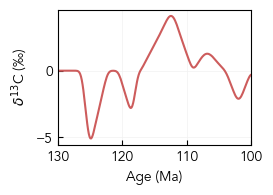

In [2]:
age_vector = np.linspace(100, 130, 250) 
amplitude = [-6, -3.5, 4.5, 1.5, -2.5]
seed = 5 
d13c_signal = stratmc.synthetics.make_excursion(age_vector, amplitude, excursion_duration = [4, 3, 8, 5, 4], rising_time = [0.3, 0.7, 0.6, 0.4, 0.5], 
                               smooth = True, smoothing_factor = 5, rate_offset = True, seed = seed, baseline = 0) # seed = 3
d13c_signal = gaussian(np.flip(d13c_signal), 3)


fs = 10

fig = plt.figure(figsize = (2.5, 1.75))
ax = fig.gca()

ax.plot(age_vector, d13c_signal, color = 'indianred', lw = 1.5) # '#87BED5'
ax.set_xlabel('Age (Ma)', fontsize = fs)
ax.set_ylabel('$\delta^{13}$C (‰)', fontsize = fs)
ax.tick_params(direction = 'in', labelsize = fs)
ax.set_axisbelow(True)
ax.grid(color=(0.95, 0.95, 0.95), linewidth=0.5, linestyle = 'solid', zorder = -1)
ax.set_xlim([130, 100])


In [3]:
def signal_func(new_ages): 
    return np.interp(new_ages, age_vector, d13c_signal)

## Generate/load synthetic data
Generate synthetic age models and proxy observations for 10 sections with depositional histories ranging from episodic (low-*k*) to continuous (high-*k*). The first 2 cells make the synthetic data; the resulting DataFrames with proxy observations and age constraint can be loaded directly in the third cell.

In [7]:
def make_path(pts,g_shape,g_scale,delta):
    #separate a number of points (X) along a [0,1] path
    if pts!=0:
        #X numbers are drawn from a gamma distribution (G)
        #--> these represent the distances between successive points
        path=np.cumsum(np.random.gamma(g_shape,g_scale, pts))
    else:
        path=[1]#if X = 0, then path is simply [0,1]
    path=np.hstack((0,path))#add 0 as the path beginning
    #scale first to be between 0 and 1, and then 0 to delta
    path=path/path[-1]*delta
    return(path)


In [21]:
delta_h = 30
g_shapes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.25, 1.5, 1.75, 2, 3, 5, 10] 
    
sections = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

sample_dfs = {}
ages_dfs = {}

# min/max ages for each section
ages = {}
ages_std = {}

ages['1'] = [130, 100.5]
ages_std['1'] = [2, 1]

ages['2'] = [128, 100]
ages_std['2'] = [1.5, 0.75]

ages['3'] = [129, 100]
ages_std['3'] = [0.8, 1]

ages['4'] = [130, 101]
ages_std['4'] = [2.5, 1.5]

ages['5'] = [130, 100]
ages_std['5'] = [2, 1.25]

ages['6'] = [129.5, 100]
ages_std['6'] = [1.25, 0.8]

ages['7'] = [130, 100.5]
ages_std['7'] = [1, 1]

ages['7'] = [130, 101]
ages_std['7'] = [1.1, 1.2]

ages['8'] = [129, 100]
ages_std['8'] = [0.9, 0.6]

ages['9'] = [130, 100]
ages_std['9'] = [1.5, 0.5]

ages['10'] = [130, 100]
ages_std['10'] = [1, 2]


age_heights = [] 

for shape in g_shapes:
    sample_ages = np.array([])
    sample_heights = np.array([]) 
    proxy_vec = np.array([])
    section_names = [] 
    age_heights = []
    ages_vec = [] 
    ages_std_vec= [] 
    age_section_names = [] 
    
    for section in sections: 
        np.random.seed(int(section) * 2)
        
        delta_t = ages[section][0] - ages[section][-1]
        
        samples = 29
        sample_ages_temp = ages[section][0] - make_path(samples, shape, 1, delta_t) #age change between knots
        sample_ages = np.append(sample_ages, sample_ages_temp)

        # make so change in height is relatively consant (to simulate a constant stratigraphic sampling rate)
        heights = make_path(samples, 100, 1, delta_h) + 0.1 # position change between knots
        sample_heights = np.append(sample_heights, heights)
        
        section_proxy = signal_func(sample_ages_temp)
        proxy_vec = np.append(proxy_vec, section_proxy)
        
        for i in np.arange(len(section_proxy)): 
            section_names.append(section)
        
        age_heights.append(0)
        age_heights.append(np.max(heights) + 0.1)
        ages_vec += ages[section]
        ages_std_vec += ages_std[section]

            
        for i in np.arange(2):
            age_section_names.append(section)
        
    
    ages_dfs[shape], sample_dfs[shape] = stratmc.synthetics.synthetic_signal_to_df(proxy_vec,
                                            sample_heights,
                                            sample_ages,
                                            section_names,
                                            ages_vec, 
                                            ages_std_vec,
                                            age_heights,
                                            age_section_names, 
                                            proxies = ['d13c'])
        
  
# save the sample and ages DataFrames
# stratmc.data.save_object(sample_dfs, 'data/Fig12_temporal_noise_sample_dfs')
# stratmc.data.save_object(ages_dfs, 'data/Fig12_temporal_noise_ages_dfs')

In [16]:
## Load sample age age DataFrames created above
g_shapes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.25, 1.5, 1.75, 2, 3, 5, 10] 
    
sections = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

sample_dfs = stratmc.data.load_object('data/Fig12_temporal_noise_sample_dfs')
ages_dfs = stratmc.data.load_object('data/Fig12_temporal_noise_ages_dfs')

## Illustrate age model construction (Fig. 6b)

### Calculate dt and dh for 4,000 synthetic age models (1,000 each for 4 sections) (for each *k*)

In [17]:
N = 1000

delta_h = 25
g_shapes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.25, 1.5, 1.75, 2, 3, 5, 10] 
    
# age constraints for 4 sections
sections_2 = ['1', '2', '3', '4']

ages = {}
ages_std = {}

ages['1'] = [125, 101]
ages_std['1'] = [2, 1]

ages['2'] = [124, 100]
ages_std['2'] = [1.5, 0.75]

ages['3'] = [124.5, 100]
ages_std['3'] = [0.8, 1]

ages['4'] = [125, 102]
ages_std['4'] = [2.5, 1.5]

np.random.seed(None)

section_age_models = {}
section_dts = {} 
dts = {} 
dhs = [] 

delta_h = 30

for section in sections_2: 
    section_age_models[section] = {} 
    section_dts[section] = {} 
for shape in tqdm(g_shapes):
    for section in sections_2:
        section_age_models[section][shape] = np.ones((N, 30)) * np.nan
        section_dts[section][shape] = np.array([])
        dts[shape] = np.array([]) 

        for n in np.arange(N): 
            delta_t = ages[section][0] - ages[section][-1]
            samples = 29
            sample_ages_temp = ages[section][0] - make_path(samples, shape, 1, delta_t) #age change between knots
            sample_heights_temp = make_path(samples, 100, 1, delta_h)
            section_age_models[section][shape][n, :] = sample_ages_temp
            section_dts[section][shape] = np.append(section_dts[section][shape], np.diff(np.flip(section_age_models[section][shape][n, :])))
            dts[shape] = np.append(dts[shape], np.diff(np.flip(section_age_models[section][shape][n, :])))
            dhs = np.append(dhs, np.diff(sample_heights_temp))

  0%|          | 0/17 [00:00<?, ?it/s]

### Plot the results (Fig. 6b)
Use the synthetic age models generated above to build probability distributions for *dt* and *dh* for different values of *k*

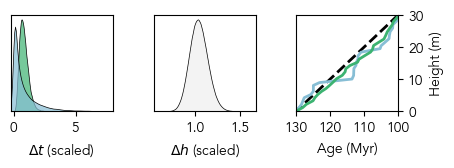

In [18]:
fs = 10 
fig, ax = plt.subplots(1, 3, figsize = (5, 1.25)) 

# deltaT
g_shape = 5
sns.kdeplot(dts[g_shape].ravel(), ax = ax[0], fill = True, color = 'mediumseagreen', alpha = 0.7, edgecolor = 'k', lw = 0.5, label=r'$k$ = %2.1f' % (g_shape));

g_shape = 0.5
sns.kdeplot(dts[g_shape].ravel(), ax = ax[0], fill = True, color = '#87BED5', alpha = 0.7, edgecolor = 'k', lw = 0.5, label=r'$k$ = %2.1f' % (g_shape))


yl = ax[0].get_ylim()
ax[0].set_ylim([0, yl[1]])
ax[0].set_xlim([-0.25, 8])

ax[0].set_ylabel('')

sns.kdeplot(dhs.ravel(), ax = ax[1], fill = True, color = 'lightgray', edgecolor = 'k', lw = 0.5)

yl = ax[1].get_ylim()
ax[1].set_ylim([0, yl[1]])
ax[1].set_ylabel('')


dt = 30
dh = 30

cs = {}
cs[0.5] = '#87BED5'
cs[5] = 'mediumseagreen'

# example dt distributions for k = 0.5 and k = 5
for shape in [0.5, 5]:
    np.random.seed(0)
    pts = 29 # set number of points equal to number of samples

    t_path=make_path(pts,shape,1,dt) #age change between knots

    # make so change in height is relatively consant (to simulate a constant stratigraphic sampling rate)
    h_path=make_path(pts,100,1,dh) #position change between knots

    ax[2].plot(130 - t_path, h_path,'-',lw=2, alpha=1, zorder = 1, color = cs[shape], label = '$k$ = ' + str(shape))
        
ax[2].plot([100, 130], [30, 0], color = 'k', lw = 2, linestyle = 'dashed', zorder = 0)

ax[2].set_xlim([130, 100])
ax[2].set_ylim([0, 30])

ax[2].set_ylabel('Height (m)', fontsize = fs)
ax[2].set_xlabel('Age (Myr)', fontsize = fs)

ax[2].yaxis.tick_right()
ax[2].yaxis.set_label_position("right")
ax[2].set_xticks([130, 120, 110, 100])
# ax[0].legend()


ax[0].set_yticks([])
ax[1].set_yticks([]) 

ax[0].set_xlabel(r'$\Delta t$ (scaled)')
ax[1].set_xlabel(r'$\Delta h$ (scaled)')


for axis in ax.ravel():
    axis.tick_params(labelsize = fs)
    
fig.subplots_adjust(wspace = 0.4)


## Plot age models for each section and *k* value

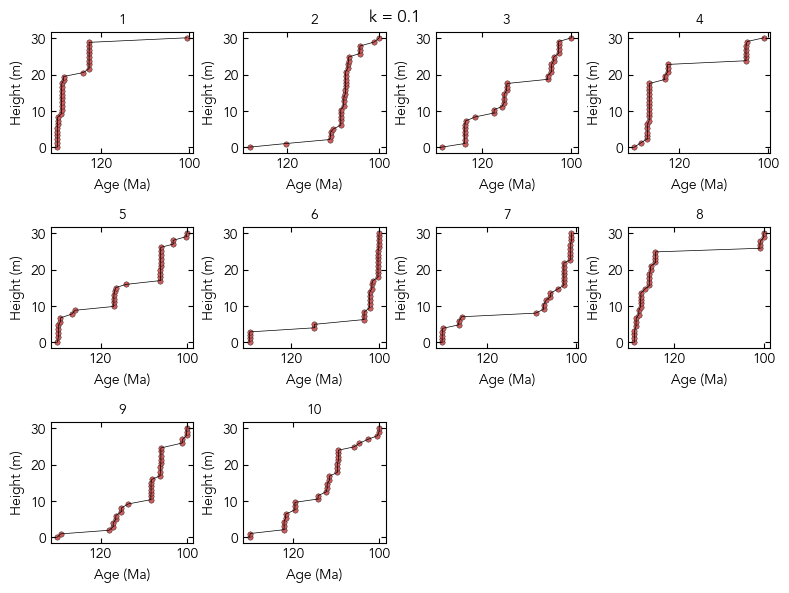

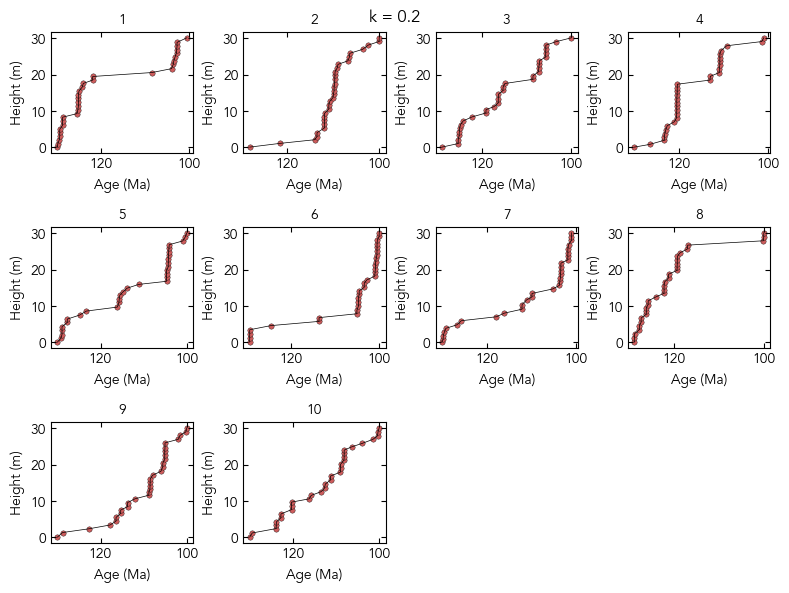

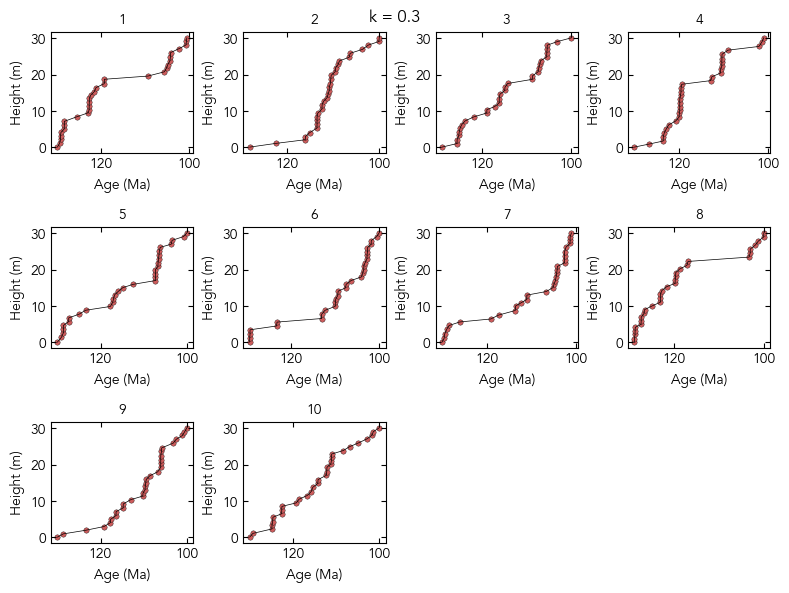

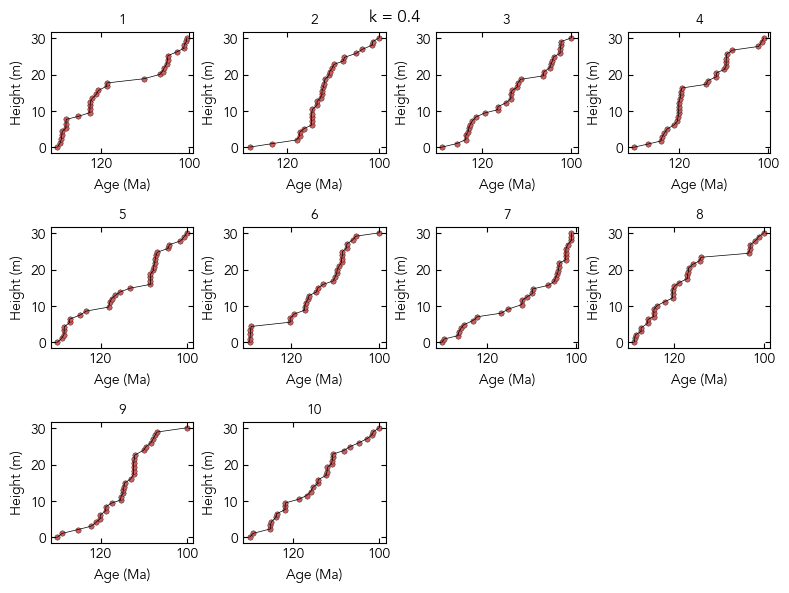

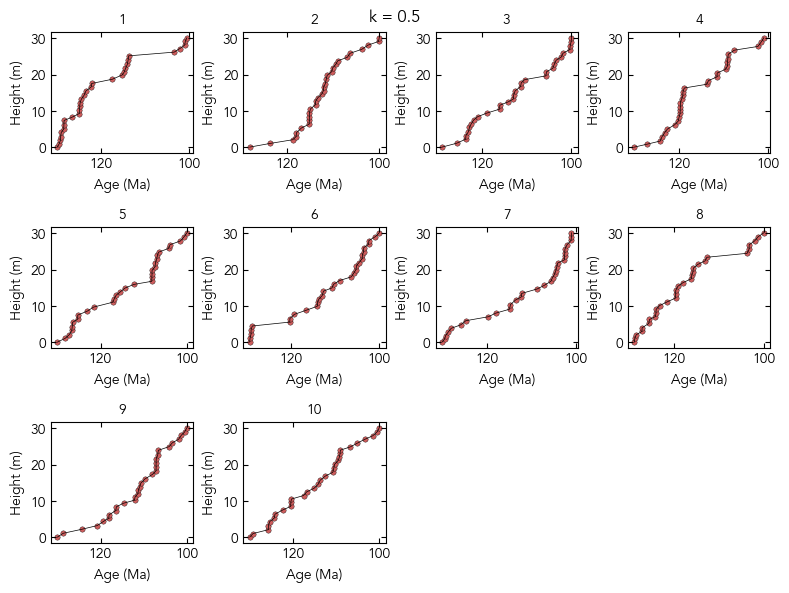

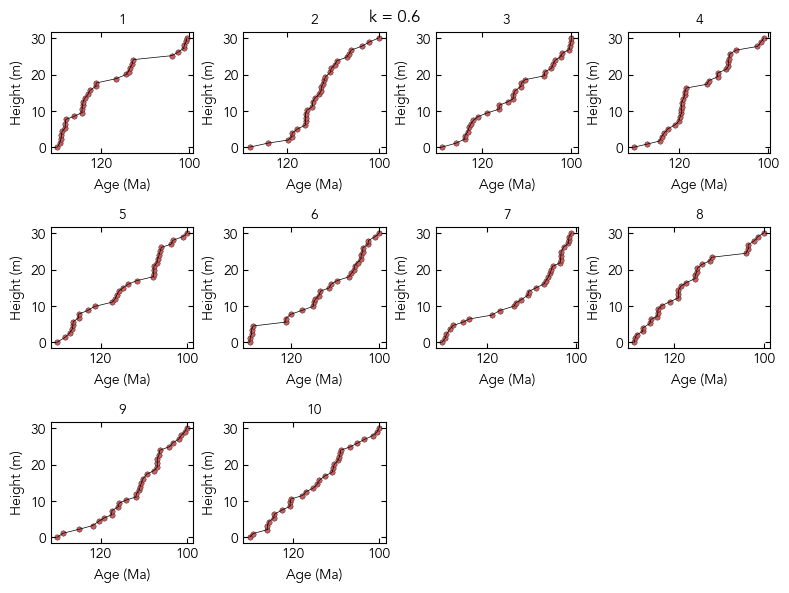

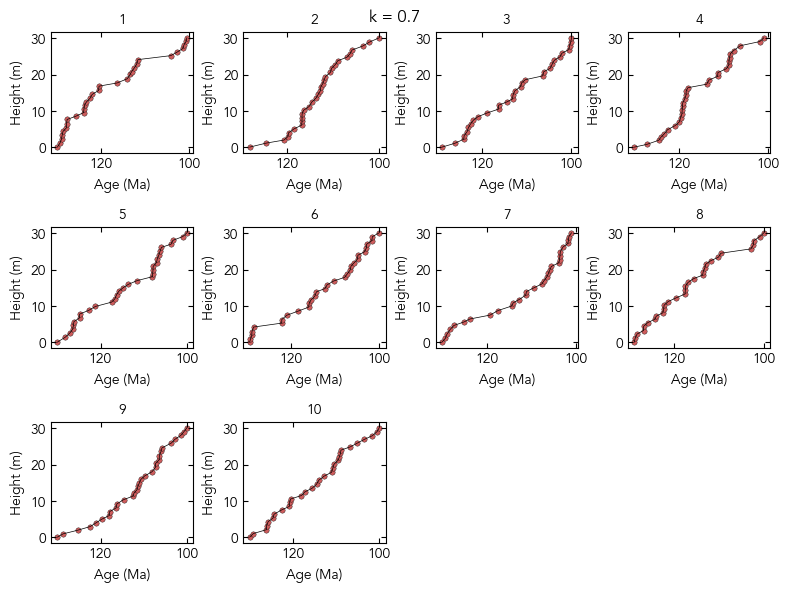

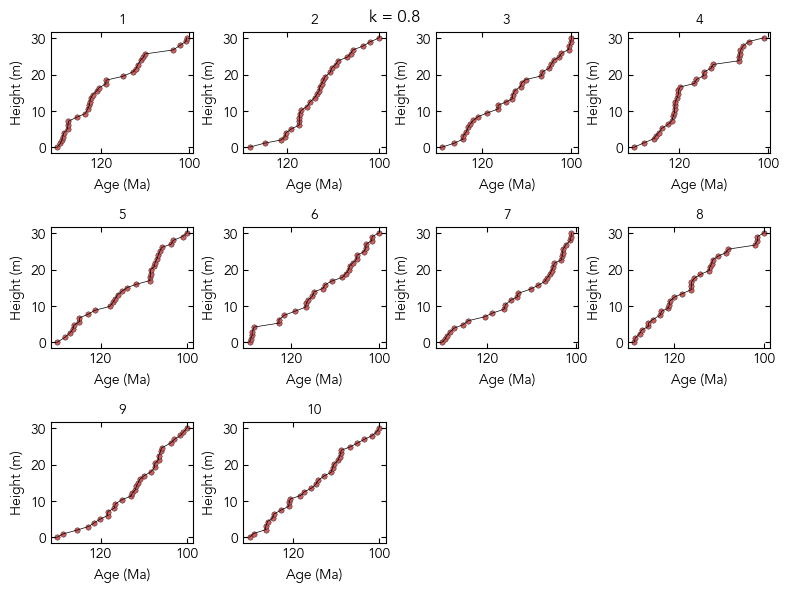

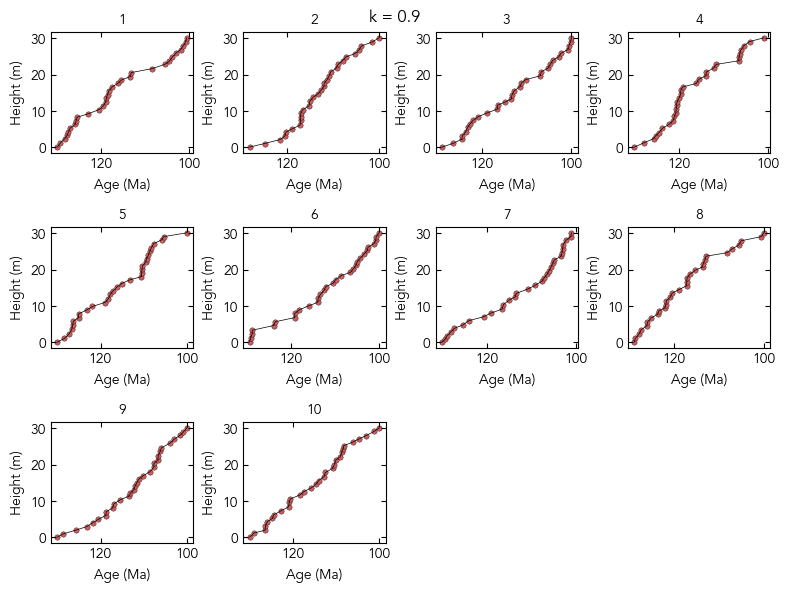

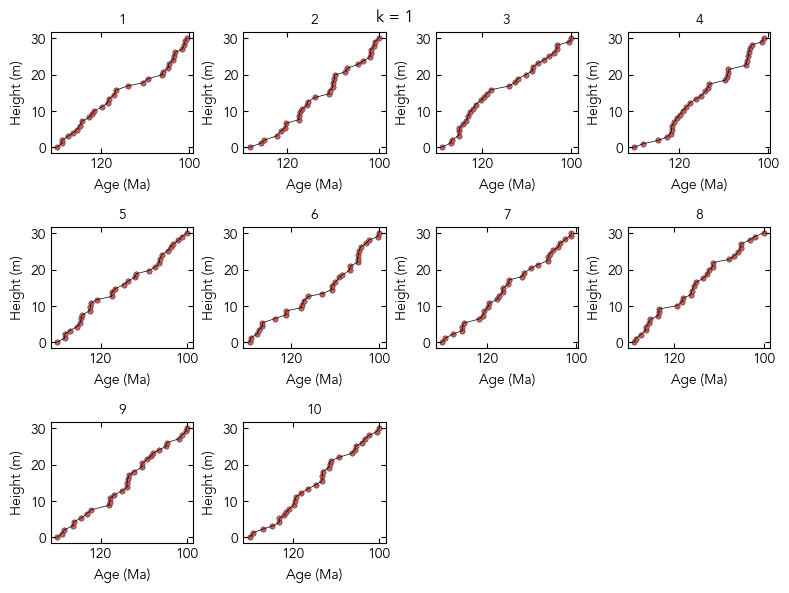

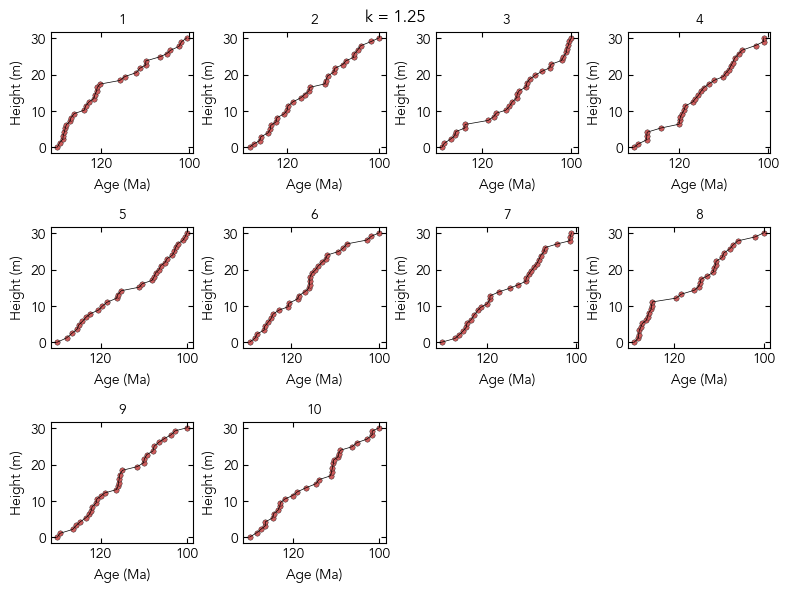

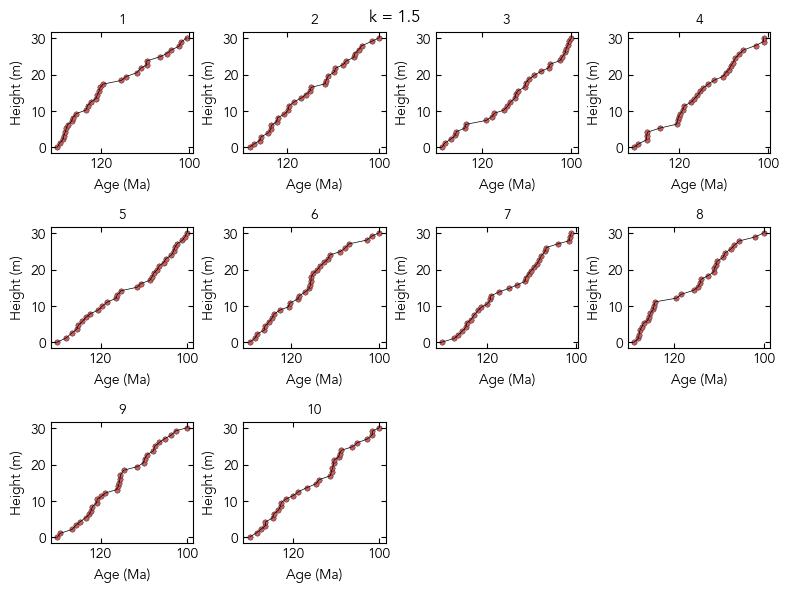

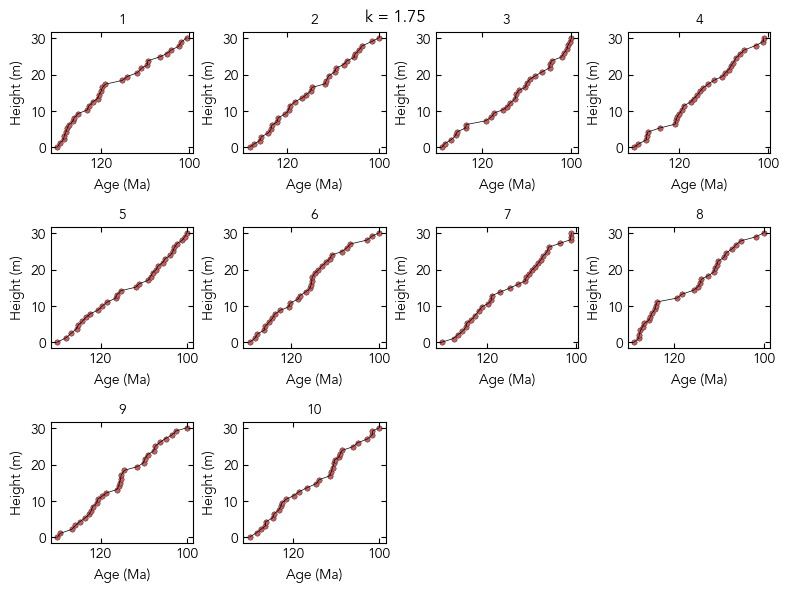

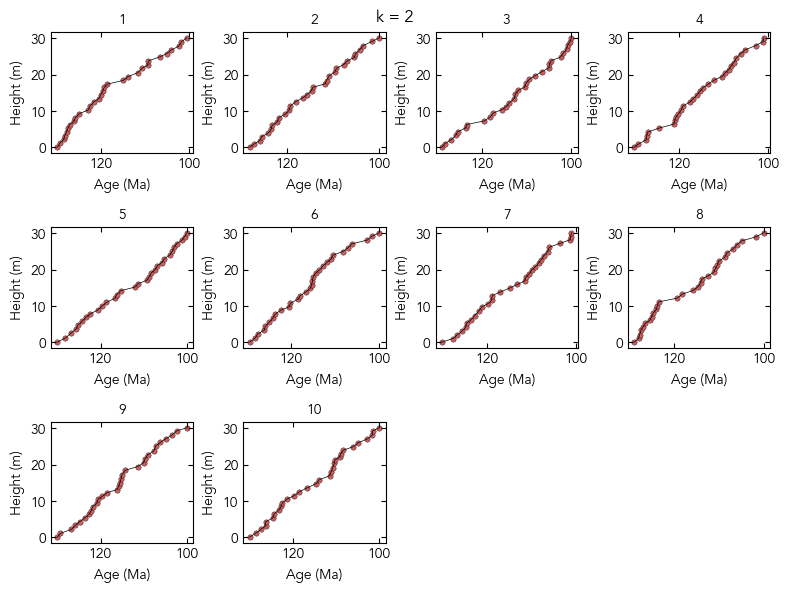

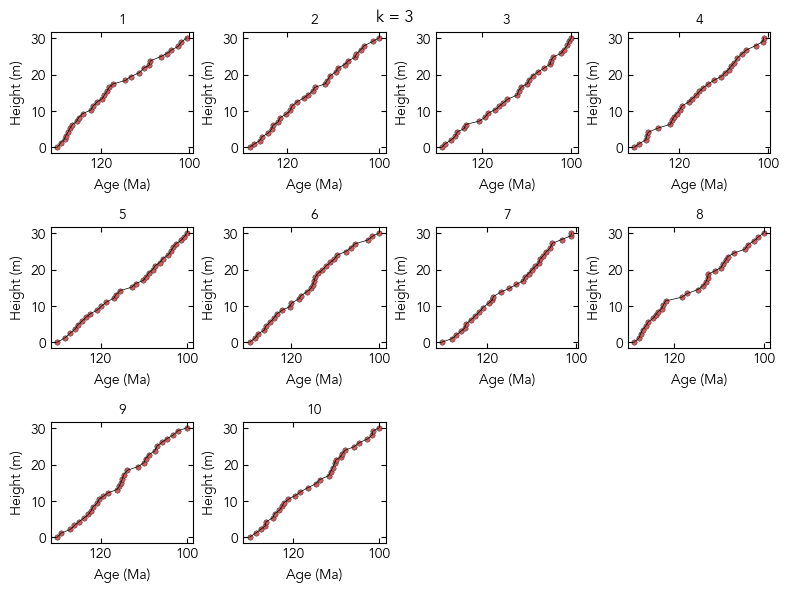

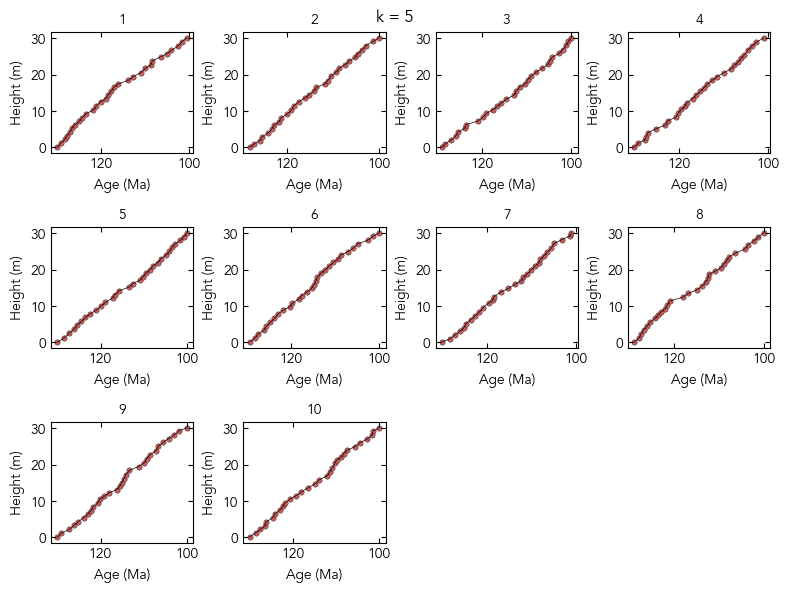

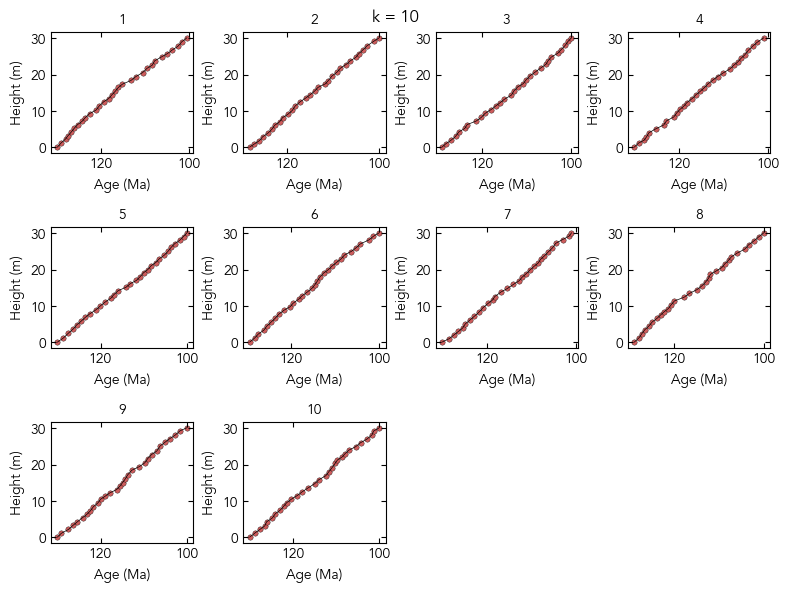

In [19]:
fs = 10 

cmap = 'Spectral'

cs = {}
pal = sns.color_palette(cmap, n_colors=len(sections))

cols = 4
N = len(sections)
rows = int(math.ceil(N/cols))


for shape in g_shapes: 
    gs = gridspec.GridSpec(rows, cols)
    fig = plt.figure(figsize = (8, 2*rows))

    for n in range(N):
        section = sections[n]
        cs[section] = pal[n]
        ax = fig.add_subplot(gs[n])

        section_df = sample_dfs[shape][sample_dfs[shape]['section'] == section]
        ax.plot(section_df['age'], section_df['height'], color = 'k', lw = 0.5, zorder = 2)
        ax.scatter(section_df['age'], section_df['height'], s = 15, color = 'indianred', edgecolor = 'k', lw = 0.25, zorder = 1)

        ax.invert_xaxis()
        
        ax.axis('tight')
        ax.set_xlabel('Age (Ma)', fontsize = fs)
        ax.set_ylabel('Height (m)', fontsize = fs)
        ax.tick_params(bottom = True, top = True, left = True, right = True, direction = 'in', labelsize = fs)
        ax.set_title(section, fontsize = fs)

    fig.tight_layout()
    
    fig.suptitle('k = ' + str(shape))

    plt.subplots_adjust(wspace=0.35) 

## Plot proxy data for first 4 example sections (for each $k$) (Fig. 6c)
The panels in Fig. 6c show the example data for $k = 0.5$ and $k = 5$

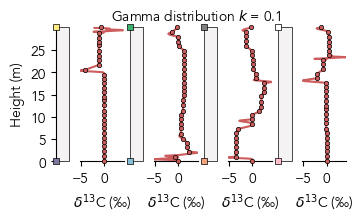

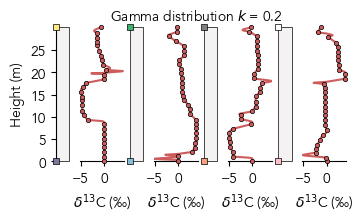

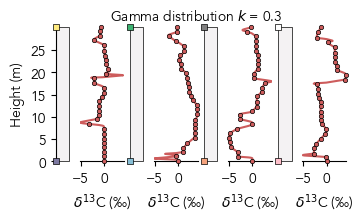

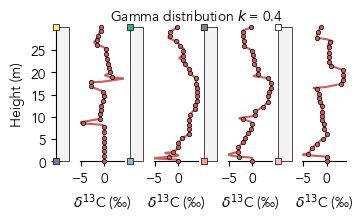

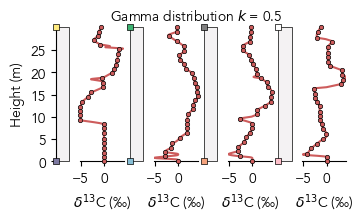

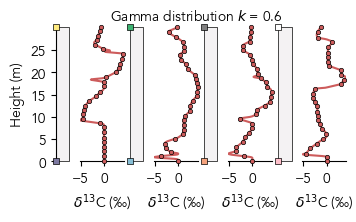

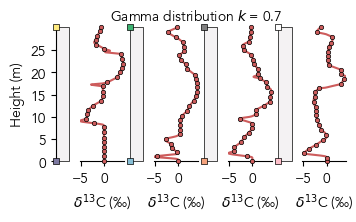

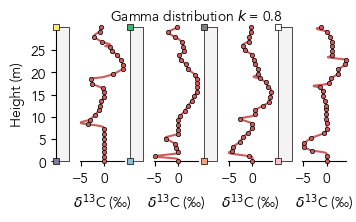

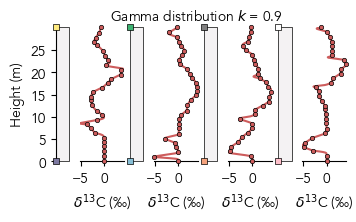

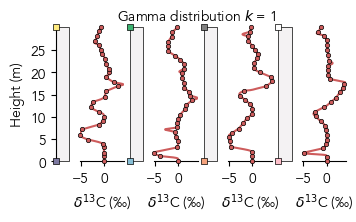

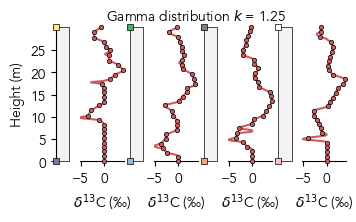

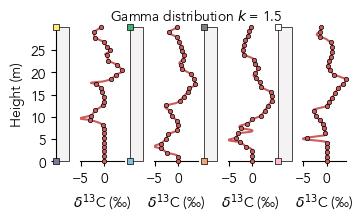

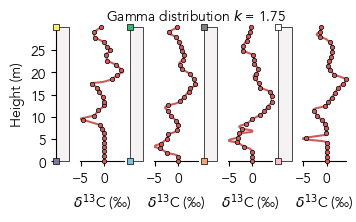

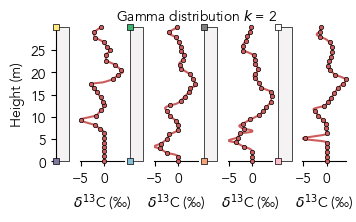

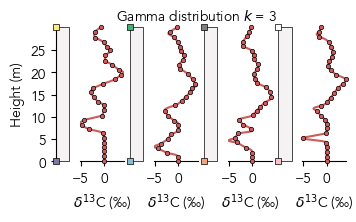

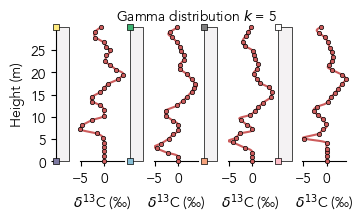

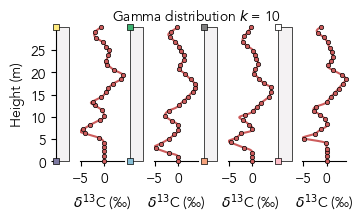

In [20]:
fs = 10 

age_colors = {} 
age_colors['1'] = ['#7C78A0', '#FFEB7F']
age_colors['2'] = ['#87BED5', 'mediumseagreen']
age_colors['3'] = ['#F4A27C', 'gray']
age_colors['4'] = ['pink', 'white']

for shape in g_shapes:

    facies_colors = {}
    facies_widths = {} 

    facies_colors['limestone'] ='#F4F2F3'

    facies_widths['limestone'] = 0.75

    section_facies = {}
    section_facies_thicknesses = {}
    # section 1
    section_facies['1'] = ['limestone']
    section_facies_thicknesses['1'] = [np.max(ages_dfs[shape][ages_dfs[shape]['section']=='1']['height'])]

    # section 2
    section_facies['2'] = ['limestone']
    section_facies_thicknesses['2'] = [np.max(ages_dfs[shape][ages_dfs[shape]['section']=='2']['height'])]

    # section 3
    section_facies['3'] = ['limestone']
    section_facies_thicknesses['3'] = [np.max(ages_dfs[shape][ages_dfs[shape]['section']=='3']['height'])]

    # section 4
    section_facies['4'] = ['limestone']
    section_facies_thicknesses['4'] = [np.max(ages_dfs[shape][ages_dfs[shape]['section']=='4']['height'])]
    
    
    widths = [0.4, 1] * 4

    fig, ax = plt.subplots(1, 2 * 4, figsize = (3.75, 1.75), sharey = True, sharex = False,  gridspec_kw={'width_ratios': widths})

    for i in np.arange(len(sections[:4])): 
        section = sections[i]

        section_ages_df = ages_dfs[shape][(ages_dfs[shape]['section'] == section) & (~np.isnan(ages_dfs[shape]['age'])) & (~ages_dfs[shape]['intermediate detrital?'])]
        section_df = sample_dfs[shape][sample_dfs[shape]['section'] == section]

        sec_sample_ages = sample_dfs[shape][sample_dfs[shape]['section'] == section]['age'].values
        sec_sample_heights = sample_dfs[shape][sample_dfs[shape]['section'] == section]['height'].values

        sec_radio_ages = section_ages_df['age'].values
        sec_ages_comb = np.concatenate([sec_radio_ages, section_df['age']])

        heights_comb = np.concatenate([section_ages_df['height'], section_df['height']])

        heights_comb_sort_idx = np.argsort(heights_comb)

        sec_ages_comb = sec_ages_comb[heights_comb_sort_idx]
        heights_comb = heights_comb[heights_comb_sort_idx]

        d13c_section_interp = np.interp(sec_ages_comb, age_vector, d13c_signal)

        new_heights = np.linspace(np.min(heights_comb), np.max(heights_comb), 500)
        sec_age_interp = np.interp(new_heights, heights_comb, sec_ages_comb)

        d13c_section_interp = np.interp(sec_age_interp, age_vector, d13c_signal)


        ax[i * 2 + 1].plot(d13c_section_interp, new_heights, c =  'indianred', zorder = 0)


        ax[i * 2 + 1].scatter(sample_dfs[shape][sample_dfs[shape]['section']==section]['d13c'], 
                              sample_dfs[shape][sample_dfs[shape]['section']==section]['height'], 
                              color = 'indianred', 
                              edgecolor = 'k', 
                              s = 10, 
                              lw = 0.5, 
                              clip_on = False, zorder = 10)

        section_ages_df = ages_dfs[shape][ages_dfs[shape]['section']==section]

        for j in np.arange(section_ages_df.shape[0]):
           
            if j == 0:  # base of sections 
                age_color = age_colors[section][0]

            if j == section_ages_df.shape[0] - 1: # top of sections
                age_color = age_colors[section][1]

            ax[i * 2].scatter(0, section_ages_df.iloc[j]['height'], color = age_color, edgecolor = 'k', marker = 's', s = 25,  lw = 0.5, zorder = 10, clip_on = False)

            ax[i * 2].set_xlim([0, 1])


        current_base = 0
        for facies, thickness in zip(section_facies[section], section_facies_thicknesses[section]): 
            ax[i * 2].barh(y = current_base,
                        width=facies_widths[facies],
                        height=thickness,
                        linewidth = 0.5,
                        edgecolor='k',
                        align='edge',
                        color=facies_colors[facies], clip_on = False)
            current_base += thickness

        ax[i * 2].set_yticklabels([])


    _ = [ax[i].sharex(ax[1]) for i in [3, 5, 7]]
    _ = [ax[i].sharey(ax[0]) for i in np.arange(1, 8)]
    
    ax[1].set_xlim([np.min(d13c_signal) - 0.1, np.max(d13c_signal) + 0.1])

    ax[1].set_ylim([0, np.max(ages_dfs[shape]['height'])])

    for i in [0, 2, 4, 6]:
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['bottom'].set_visible(False)
        ax[i].spines['left'].set_visible(False)
        ax[i].set_xlim([0, 1])
        ax[i].set_xticks([])

    for i in [1, 3, 5, 7]:
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['bottom'].set_visible(True)
        ax[i].spines['left'].set_visible(False)
        ax[i].set_xlabel('$\delta^{13}$C (‰)', fontsize = fs) 


    for axis in ax.ravel():
        axis.set_axisbelow(True)
        axis.set_yticks([])
        axis.tick_params(labelsize = fs)

    ax[0].tick_params(labelsize = fs)

    ax[0].spines['left'].set_visible(True)
    ax[0].set_ylabel('Height (m)', fontsize = fs) 


    ax[0].set_yticks([0, 5, 10, 15, 20, 25]) 
    ax[0].set_yticklabels([0, 5, 10, 15, 20, 25]) 


    for i in np.arange(1, 8): 
        [t.set_color('none') for t in ax[i].yaxis.get_ticklabels()]
        ax[i].tick_params(axis = 'y', color = 'none')
        
    fig.suptitle('Gamma distribution $k$ = ' + str(shape), fontsize = fs)



## Run experiments (build and sample the inference model)
Runs the inference model in a loop that iterates over each value of $k$, and plots each proxy signal inference. Include different subsets of sections by modifying `section_group` in the first cell. Fig. 12b uses `section_group = ['1', '2', '3', '4']`. The two-section experiments in Fig. 12c use `section_group = ['1', '2']`, and the ten-section experiment uses `section_group = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']`.

The traces for each experiment included in Fig. 12 can be loaded in [Load the inference results](#Load-the-inference-results).

In [2]:
section_group = ['1', '2', '3', '4']

In [47]:
age_min = 100
age_max = 130

predict_ages = np.arange(age_min, age_max + 0.25, 0.25)[:,None]

for shape in g_shapes[:2]:

    model, gp = stratmc.model.build_model(sample_dfs[shape], 
                            ages_dfs[shape],  
                            sections = section_group,
                            proxies = ['d13c'],
                            ls_dist = 'Wald',
                            ls_min = 2, 
                            ls_mu = 4, 
                            ls_lambda = 15, 
                            noise_type = 'section', # per-section noise with default prior
                            offset_type = 'section', # per-section offset with default prior
                            )

    extension = 'Fig12_temporal_noise_k_' + str(shape) + '_sections_' 

    for s in section_group: 
         extension += str(s) + '_'

    full_trace = stratmc.inference.get_trace(model, 
                                           gp, 
                                           predict_ages,
                                           sample_dfs[shape], 
                                           ages_dfs[shape], 
                                           proxies = ['d13c'], 
                                           name = extension, 
                                           chains = 100, 
                                           target_accept = 0.9
                                          ) 


    fig = stratmc.plotting.proxy_inference(sample_dfs[shape], ages_dfs[shape], full_trace, sections=section_group, 
                      orientation = 'horizontal', plot_constraints = True, plot_data = True, plot_excluded_samples = True, 
                      legend = False, plot_mle = True, section_legend = True, proxy = 'd13c')

    ax = fig.gca()
    ax.plot(age_vector, d13c_signal, color = 'indianred', label = 'True Signal', zorder = 10)

    plt.title('k = ' + str(shape))

    plt.legend()

    plt.show()


## Load the inference results

Load the traces required to reproduce Fig. 12. 

In [21]:
# Paths to traces for models that include 4 sections (1, 2, 3, and 4); keys are k values

trace_paths_4_sec = {} 

trace_paths_4_sec[0.1] = 'traces/Fig12_temporal_noise_k_0.1_sections_1_2_3_4'
trace_paths_4_sec[0.2] = 'traces/Fig12_temporal_noise_k_0.2_sections_1_2_3_4'
trace_paths_4_sec[0.3] = 'traces/Fig12_temporal_noise_k_0.3_sections_1_2_3_4'
trace_paths_4_sec[0.4] = 'traces/Fig12_temporal_noise_k_0.4_sections_1_2_3_4'
trace_paths_4_sec[0.5] = 'traces/Fig12_temporal_noise_k_0.5_sections_1_2_3_4'
trace_paths_4_sec[0.6] = 'traces/Fig12_temporal_noise_k_0.6_sections_1_2_3_4'
trace_paths_4_sec[0.7] = 'traces/Fig12_temporal_noise_k_0.7_sections_1_2_3_4'
trace_paths_4_sec[0.8] = 'traces/Fig12_temporal_noise_k_0.8_sections_1_2_3_4'
trace_paths_4_sec[0.9] = 'traces/Fig12_temporal_noise_k_0.9_sections_1_2_3_4'
trace_paths_4_sec[1] = 'traces/Fig12_temporal_noise_k_1_sections_1_2_3_4'
trace_paths_4_sec[1.25] = 'traces/Fig12_temporal_noise_k_1.25_sections_1_2_3_4'
trace_paths_4_sec[1.5] = 'traces/Fig12_temporal_noise_k_1.5_sections_1_2_3_4'
trace_paths_4_sec[1.75] = 'traces/Fig12_temporal_noise_k_1.75_sections_1_2_3_4'
trace_paths_4_sec[2] = 'traces/Fig12_temporal_noise_k_2_sections_1_2_3_4'
trace_paths_4_sec[3] = 'traces/Fig12_temporal_noise_k_3_sections_1_2_3_4'
trace_paths_4_sec[5] = 'traces/Fig12_temporal_noise_k_5_sections_1_2_3_4'
trace_paths_4_sec[10] = 'traces/Fig12_temporal_noise_k_10_sections_1_2_3_4'

In [22]:
# Paths to relevant traces for models that include 2 sections (1 and 2); keys are k values
trace_paths_2_sec = {} 
trace_paths_2_sec[0.5] = 'traces/Fig12_temporal_noise_k_0.5_sections_1_2'
trace_paths_2_sec[10] = 'traces/Fig12_temporal_noise_k_10_sections_1_2'

In [23]:
# Path to example 10-section trace (k = 0.5)
trace_paths_10_sec = {} 
trace_paths_10_sec[0.5] = 'traces/Fig12_temporal_noise_k_0.5_sections_1_2_3_4_5_6_7_8_9_10'

## Quantify signal recovery 
Calculate or load relative model likelihoods (used to compare synthetic proxy signal recovery for different models) plotted in Fig. 12b-c. To load the results instead of re-running the calculations, skip to [Load calculated relative model likelihoods](#Load-calculated-relative-model-likelihoods). 

### 4-section experiments (Fig. 12b)

In [12]:
# interpolate proxy signal to same ages where proxy signal was inferred
full_trace = stratmc.data.load_trace(trace_paths_4_sec[0.1])

predict_ages = full_trace.X_new.X_new.values
del full_trace

d13c_signal_interp = np.interp(predict_ages, age_vector, d13c_signal)


/Users/staceyedmonsond/opt/anaconda3/envs/bayestrat-dev-m1-pymc516-accelerate/lib/python3.11/site-packages/arviz/data/inference_data.py:157: UserWarning: X_new group is not defined in the InferenceData scheme
  warnings.warn(


In [64]:
# 4 sections 
signal_recovery_4_sec = {} 
age_recovery_4_sec = {} 
age_likelihood_vec_4_sec = {} 
variance_reduction_4_sec = {} 

for shape in tqdm(g_shapes): 
    full_trace_4_sec = stratmc.data.load_trace(trace_paths_4_sec[shape])

    signal_recovery_4_sec[shape] = stratmc.synthetics.quantify_signal_recovery(full_trace_4_sec, d13c_signal_interp, proxy = 'd13c')
    
signal_total_4_sec = np.zeros_like(np.array(signal_recovery_4_sec[shape]))
for shape in g_shapes: 
    signal_total_4_sec += np.array(signal_recovery_4_sec[shape])
    
relative_model_likelihood_4_sec = {} 

for shape in g_shapes: 
    relative_model_likelihood_4_sec[shape] = np.array(signal_recovery_4_sec[shape])/signal_total_4_sec

del full_trace_4_sec
    
# stratmc.data.save_object(relative_model_likelihood_4_sec, 'data/Fig12b_relative_model_likelihood_4_sections')
                                      

  0%|          | 0/17 [00:00<?, ?it/s]

### Example inferences with different numbers of sections (Fig. 12c)

In [73]:
## compare specific models: 
# 2 sections, k = 10
# 2 sections, i = 0.5
# 10 sections, k = 0.5

signal_total_paper_comparison = 0

signal_recovery_paper = {} 

full_trace = stratmc.data.load_trace(trace_paths_2_sec[10])
signal_recovery_paper['2_sec_k_10'] = stratmc.synthetics.quantify_signal_recovery(full_trace, d13c_signal_interp, proxy = 'd13c')

full_trace = stratmc.data.load_trace(trace_paths_2_sec[0.5])
signal_recovery_paper['2_sec_k_05'] = stratmc.synthetics.quantify_signal_recovery(full_trace, d13c_signal_interp, proxy = 'd13c')
  
full_trace = stratmc.data.load_trace(trace_paths_10_sec[0.5])
signal_recovery_paper['10_sec_k_05'] = stratmc.synthetics.quantify_signal_recovery(full_trace, d13c_signal_interp, proxy = 'd13c')
                                  
signal_total_paper = np.zeros_like(np.array(signal_recovery_paper['2_sec_k_10']))
for shape in list(signal_recovery_paper.keys()): 
    signal_total_paper += np.array(signal_recovery_paper[shape])
    
relative_model_likelihood_Fig12c = {} 

for shape in list(signal_recovery_paper.keys()): 
    relative_model_likelihood_Fig12c[shape] = np.array(signal_recovery_paper[shape])/signal_total_paper
    
# stratmc.data.save_object(relative_model_likelihood_Fig12c, 'data/Fig12c_relative_model_likelihood')


### Load calculated relative model likelihoods


In [24]:
relative_model_likelihood_4_sec = stratmc.data.load_object('data/Fig12b_relative_model_likelihood_4_sections')
relative_model_likelihood_Fig12c = stratmc.data.load_object('data/Fig12c_relative_model_likelihood')

## Plot the results (Fig. 12)

/Users/staceyedmonsond/opt/anaconda3/envs/bayestrat-dev-m1-pymc516-accelerate/lib/python3.11/site-packages/arviz/data/inference_data.py:157: UserWarning: X_new group is not defined in the InferenceData scheme
  warnings.warn(


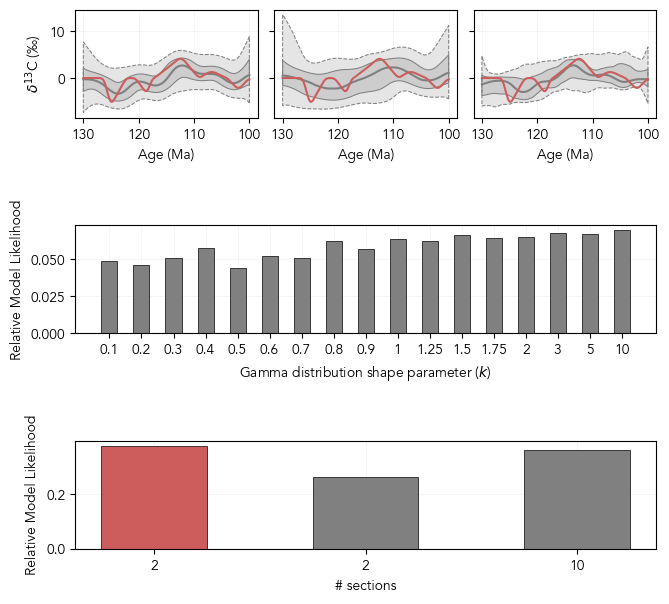

In [25]:
mosaic = """
    112233
    444444
    555555
    """

fs = 10
fig, ax = plt.subplot_mosaic(mosaic,  figsize = (7.5, 7), sharex = False, sharey = False, constrained_layout = False)

ax['1'].sharex(ax['2'])
ax['2'].sharex(ax['3'])
ax['1'].sharey(ax['2'])
ax['2'].sharey(ax['3'])

# 2 sections, k = 10
shape = 10
full_trace = stratmc.data.load_trace(trace_paths_2_sec[shape])
predict_ages = full_trace.X_new.X_new.values
proxy_pred = az.extract(full_trace.posterior_predictive)['f_pred_' + 'd13c'].values

hi = np.percentile(proxy_pred, 97.5, axis=1).flatten()

lo = np.percentile(proxy_pred, 2.5, axis=1).flatten()

ax['1'].fill_between(predict_ages.ravel(),
                        hi,
                        lo,
                        color= "white",
                        linestyle = '--', 
                        edgecolor = "none", 
                        alpha = 1,
                        lw = 0,  # 1.5
                        zorder = 1)

ax['1'].fill_between(predict_ages.ravel(),
                         hi,
                        lo,
                        color = 'black',
                        linestyle = '--', 
                        edgecolor = "none", 
                        alpha = 0.1,
                        lw = 0,  # 1.5
                        zorder = 2)

ax['1'].fill_between(predict_ages.ravel(),
                         hi,
                        lo,
                        color= "none", 
                        label='95% envelope',  
                        linestyle = '--', 
                        edgecolor = 'gray', 
                        alpha = 1,
                        lw = 0.75, 
                        zorder = 3)

hi = np.percentile(proxy_pred, 100-16, axis=1).flatten()

lo = np.percentile(proxy_pred, 16, axis=1).flatten()

ax['1'].fill_between(predict_ages.ravel(),
                        hi,
                        lo,
                        color = 'black',
                        edgecolor = "none",
                        alpha = 0.1, 
                        lw = 0, # 1.5
                        zorder = 4)

ax['1'].fill_between(predict_ages.ravel(),
                        hi,
                        lo,
                        color="none",
                        label='68% envelope',
                        edgecolor = 'gray', 
                        alpha = 1, 
                        lw = 0.75, # 1.5
                        zorder = 5)

dy = np.linspace(np.min(proxy_pred), np.max(proxy_pred), 400)
max_like = np.zeros(predict_ages.size)
for i in np.arange(predict_ages.size):
    time_slice = proxy_pred[i, :]
    max_like[i] = dy[np.argmax(gaussian_kde(time_slice, bw_method = 1)(dy))]

max_like = gaussian(max_like, 2)
ax['1'].plot(predict_ages.ravel(),max_like, color = 'gray', linestyle = 'solid', lw = 1.5, zorder = 6, label = 'Most likely $\delta^{13}$C')

ax['1'].plot(age_vector, d13c_signal, color = 'indianred', lw = 1.5, label = 'True Signal', zorder = 10)

# 2 sections, k = 0.5
shape = 0.5
full_trace = stratmc.data.load_trace(trace_paths_2_sec[shape])
predict_ages = full_trace.X_new.X_new.values
proxy_pred = az.extract(full_trace.posterior_predictive)['f_pred_' + 'd13c'].values

hi = np.percentile(proxy_pred, 97.5, axis=1).flatten()

lo = np.percentile(proxy_pred, 2.5, axis=1).flatten()

ax['2'].fill_between(predict_ages.ravel(),
                        hi,
                        lo,
                        color= "white",
                        linestyle = '--', 
                        edgecolor = "none", 
                        alpha = 1,
                        lw = 0,  # 1.5
                        zorder = 1)

ax['2'].fill_between(predict_ages.ravel(),
                         hi,
                        lo,
                        color = 'black',
                        linestyle = '--', 
                        edgecolor = "none", 
                        alpha = 0.1,
                        lw = 0,  # 1.5
                        zorder = 2)

ax['2'].fill_between(predict_ages.ravel(),
                         hi,
                        lo,
                        color= "none",
                        label='95% envelope',  
                        linestyle = '--', 
                        edgecolor = 'gray', 
                        alpha = 1,
                        lw = 0.75,  # 1.5
                        zorder = 3)

hi = np.percentile(proxy_pred, 100-16, axis=1).flatten()

lo = np.percentile(proxy_pred, 16, axis=1).flatten()

ax['2'].fill_between(predict_ages.ravel(),
                        hi,
                        lo,
                        color = 'black',
                        edgecolor = "none",
                        alpha = 0.1, 
                        lw = 0, # 1.5
                        zorder = 4)

ax['2'].fill_between(predict_ages.ravel(),
                        hi,
                        lo,
                        color="none",
                        label='68% envelope',
                        edgecolor = 'gray',
                        alpha = 1, 
                        lw = 0.75, # 1.5
                        zorder = 5)

dy = np.linspace(np.min(proxy_pred), np.max(proxy_pred), 400)
max_like = np.zeros(predict_ages.size)
for i in np.arange(predict_ages.size):
    time_slice = proxy_pred[i, :]
    max_like[i] = dy[np.argmax(gaussian_kde(time_slice, bw_method = 1)(dy))]

max_like = gaussian(max_like, 2)
ax['2'].plot(predict_ages.ravel(),max_like, color = 'gray', linestyle = 'solid', lw = 1.5, zorder = 6, label = 'Most likely $\delta^{13}$C')

ax['2'].plot(age_vector, d13c_signal, color = 'indianred', lw = 1.5, label = 'True Signal', zorder = 10)

# shape = 0.5, 10 sections
shape = 0.5
full_trace = stratmc.data.load_trace(trace_paths_10_sec[shape])
predict_ages = full_trace.X_new.X_new.values
proxy_pred = az.extract(full_trace.posterior_predictive)['f_pred_' + 'd13c'].values

hi = np.percentile(proxy_pred, 97.5, axis=1).flatten()

lo = np.percentile(proxy_pred, 2.5, axis=1).flatten()

ax['3'].fill_between(predict_ages.ravel(),
                        hi,
                        lo,
                        color= "white",
                        linestyle = '--', 
                        edgecolor = "none", 
                        alpha = 1,
                        lw = 0,  # 1.5
                        zorder = 1)

ax['3'].fill_between(predict_ages.ravel(),
                         hi,
                        lo,
                        color = 'black',
                        linestyle = '--', 
                        edgecolor = "none", 
                        alpha = 0.1,
                        lw = 0,  # 1.5
                        zorder = 2)

ax['3'].fill_between(predict_ages.ravel(),
                         hi,
                        lo,
                        color= "none", 
                        label='95% envelope',  
                        linestyle = '--', 
                        edgecolor = 'gray', 
                        alpha = 1,
                        lw = 0.75, 
                        zorder = 3)

hi = np.percentile(proxy_pred, 100-16, axis=1).flatten()

lo = np.percentile(proxy_pred, 16, axis=1).flatten()

ax['3'].fill_between(predict_ages.ravel(),
                        hi,
                        lo,
                        color = 'black',
                        edgecolor = "none",
                        alpha = 0.1, 
                        lw = 0, # 1.5
                        zorder = 4)

ax['3'].fill_between(predict_ages.ravel(),
                        hi,
                        lo,
                        color="none",
                        label='68% envelope',
                        edgecolor = 'gray', 
                        alpha = 1, 
                        lw = 0.75, # 1.5
                        zorder = 5)

dy = np.linspace(np.min(proxy_pred), np.max(proxy_pred), 400)
max_like = np.zeros(predict_ages.size)
for i in np.arange(predict_ages.size):
    time_slice = proxy_pred[i, :]
    max_like[i] = dy[np.argmax(gaussian_kde(time_slice, bw_method = 1)(dy))]

max_like = gaussian(max_like, 2)
ax['3'].plot(predict_ages.ravel(),max_like, color = 'gray', linestyle = 'solid', lw = 1.5, zorder = 6, label = 'Most likely $\delta^{13}$C')

ax['3'].plot(age_vector, d13c_signal, color = 'indianred', lw = 1.5, label = 'True Signal', zorder = 10)


for i, shape in enumerate(g_shapes):
    ax['4'].bar(i, np.mean(relative_model_likelihood_4_sec[shape]), width = 0.5, color = 'gray', edgecolor = 'k', lw = 0.5)
        
ax['4'].set_xticks(np.arange(len(g_shapes)));
ax['4'].set_xticklabels(g_shapes); # np.round(g_shapes, 1)
ax['4'].set_xlabel('Gamma distribution shape parameter ($k$)', fontsize = fs)
ax['4'].set_ylabel('Relative Model Likelihood', fontsize = fs)

ax['4'].tick_params(labelsize = fs)

paper_vec = []
for shape in list(relative_model_likelihood_Fig12c.keys()): 
    paper_vec.append(np.mean(relative_model_likelihood_Fig12c[shape]))
    
ax['5'].bar(np.arange(1), paper_vec[0], width = 0.5, color = 'indianred', edgecolor = 'k', lw = 0.5)

ax['5'].bar(np.arange(1, len(paper_vec)), paper_vec[1:], width = 0.5, color = 'gray', edgecolor = 'k', lw = 0.5)

labels = [2, 2, 10]

ax['5'].set_xlabel('# sections', fontsize = fs)
ax['5'].set_ylabel('Relative Model Likelihood', fontsize = fs)

ax['5'].set_xticks(np.arange(len(paper_vec)))
ax['5'].set_xticklabels(labels)

for i in '123':
    ax[i].set_xlabel('Age (Ma)', fontsize = fs)
    
ax['1'].set_ylabel('$\delta^{13}$C (‰)', fontsize = fs)

ax['1'].invert_xaxis()


for i in '12345': 
    ax[i].set_axisbelow(True)
    ax[i].grid(color=(0.95, 0.95, 0.95), linewidth=0.5, linestyle = 'solid', zorder = -1)
    ax[i].tick_params(labelsize = fs)
    
[t.set_color('none') for t in ax['2'].yaxis.get_ticklabels()]
[t.set_color('none') for t in ax['3'].yaxis.get_ticklabels()]
    
fig.subplots_adjust(hspace = 1)
